In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.append('../..')

In [2]:
from tqdm import tqdm
from supergear import SuperGear, calculate_R

In [3]:
from lamarck.assistant import GenomeCreator
from lamarck.assistant import PopulationCreator
from lamarck import Environment

# Mini process example - gear optimization

### Process

$\omega_1 = \omega * R$

$R = \frac{\omega_1'}{\omega}$

$R = \frac{z_1 + z_3}{z_1 - z_1' \frac{z_3}{z_3'}}$

$\omega_1' = R * \omega$

$\omega_2' = \omega_1' * \frac{2*z_1'}{z_3' - z_1'}$

$\omega_2 = \omega_1' * \frac{z_1 + z_1' \frac{z_3}{z_3'}}{z_3 - z_1}$

having the $\omega'$s as the $input$ side and the $\omega$s as the $output$ side

In [4]:
def compute_gear(z1i, z1o, di, do):
    z3i = z1i + di
    z3o = z1o + do
    if z3o/z3i == z1o/z1i:
        return {
            'R': 0,
            'DiameterRatio': 100,
        }
    else:
        return {
            'R': abs(calculate_R(z1o, z3o, z1i, z3i)),
            'DiameterRatio': max(z3i/z3o, z3o/z3i),
        }

### Optimization

#### Genome Creation

In [5]:
genome_creator = GenomeCreator()

genome_creator.add_gene_specs.numeric(name='z1i',
                                      min=30,
                                      max=60,
                                      progression='linear',
                                      domain='int')

genome_creator.add_gene_specs.numeric(name='z1o',
                                      min=30,
                                      max=60,
                                      progression='linear',
                                      domain='int')

genome_creator.add_gene_specs.numeric(name='di',
                                      min=30,
                                      max=180,
                                      progression='linear',
                                      domain='int')

genome_creator.add_gene_specs.numeric(name='do',
                                      min=30,
                                      max=180,
                                      progression='linear',
                                      domain='int')

genome_blueprint = genome_creator.get_genome_blueprint()

In [ ]:
pop_creator = PopulationCreator(genome_blueprint)

#### Simulate Serial

Population

In [6]:
pop = pop_creator.create.det(7) + pop_creator.create.rand(2000)
pop.define()
pop

Population with 4401 Creatures with genes z1i (numeric), z1o (numeric), di (numeric), do (numeric).
        

<AxesSubplot:xlabel='z1i', ylabel='z1o'>

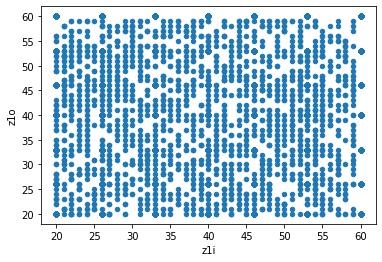

In [8]:
pop.plot.variable_pair('z1i', 'z1o')

Environment

In [9]:
env = Environment()
env.config.set_multi(False)
env.config.set_process(compute_gear)
outputs = ['R', 'DiameterRatio']
objectives = ['max', 'min']
env.config.set_output_varibles(*outputs)

In [10]:
# iterarions
n_generations = 20
pbar = tqdm(range(n_generations))
R = 0
for _ in pbar:
    pbar.set_description(f'[max R: {R}] Simulating...')
    env.simulate(pop)
    R = round(pop.datasets.output['R'].max(), 2)
    pbar.set_description(f'[max R: {R}] Applying Fitness Criteria...')
    pop.apply_fitness.multi_objective.pareto(outputs, objectives=objectives)
    pbar.set_description(f'[max R: {R}] Selecting...')
    pop = pop.select()
    pbar.set_description(f'[max R: {R}] Generating Offspring...')
    pop.reproduce.tournament(n_dispute=2)

[max R: 42823.0] Generating Offspring...: 100%|██████████| 20/20 [16:10<00:00, 48.51s/it]     


<AxesSubplot:xlabel='generation', ylabel='DiameterRatio'>

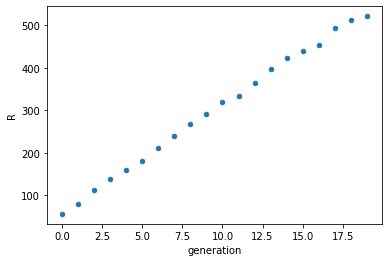

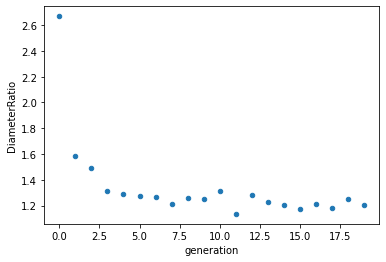

In [23]:
pop.plot.history('R', 'mean')
pop.plot.history('DiameterRatio', 'mean')

<AxesSubplot:xlabel='DiameterRatio', ylabel='R'>

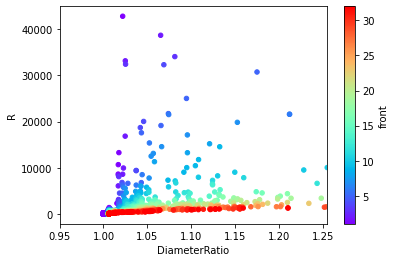

In [30]:
pop.plot.fronts(x='DiameterRatio', y='R', xlim=(0.95, 1.255))

In [31]:
pop.datasets.fitness

,z1i,z1o,di,do,R,DiameterRatio,criteria0,criteria1,front,crowd
id,,,,,,,,,,
-7591026460462084478,48,20,66,94,4.785714,1.000000,-0.246604,-0.060060,1.0,inf
1525785286617851104,47,46,140,137,42823.000000,1.021858,20.178223,-0.053508,1.0,inf
7677142254259258754,32,53,106,85,9.095238,1.000000,-0.244548,-0.060060,1.0,inf
4081329764494348248,59,58,115,113,13282.000000,1.017544,6.086795,-0.054801,1.0,15.334592
-1925941739584333781,59,58,123,121,8626.800000,1.016760,3.866206,-0.055036,1.0,3.998523
...,...,...,...,...,...,...,...,...,...,...
3506857804665357961,44,46,48,49,NaN,NaN,NaN,NaN,NaN,NaN
89660999858288062,46,42,125,99,NaN,NaN,NaN,NaN,NaN,NaN
-4380755009424265921,46,46,95,123,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
calculate_R(47, 187, 46, 183)

-42822.00000000517